## RNN и языковые модели 


In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [24]:
!pip3 install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
import torch
import numpy as np
from dataset import TextDataset

In [26]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

In [27]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length, )
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Language model

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `EOS` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью. 

In [28]:
from model import LanguageModel
from train import train
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE = device
print(device)

cuda:0


In [29]:
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

model = LanguageModel(train_set)

In [30]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, ))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

## Training

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится. 

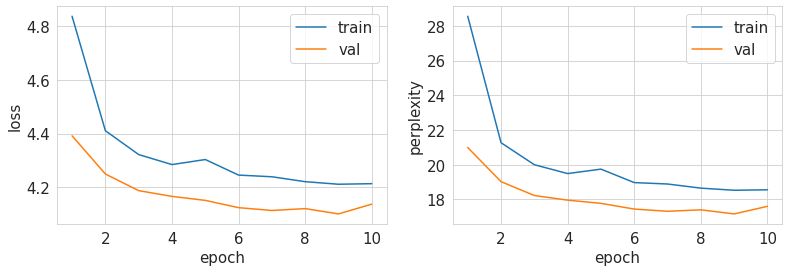

Generation examples:
штирлиц собирается открывается или самая 10 миллионов презрение это пускать яйца.
подхожу, когда в бебраем, построилось к те.
в бампечнице не ела.
только переслу купить это-нибудь, а подворот тест, абрам эсэ старальное место в жизни дело авахринт, будто существующего в русском и сколько нужно сервее, поэтому будут территории управление первых четветно больше люблю. поэтому это в лавочке же завернут на пляже получается.
причем очень важно, чем возьму рутая - против в мире после соворовки.- расскажите. какой гирк запреты расстрелал или изменить!- опять, товарищи виноват.


In [31]:
model1 = LanguageModel(train_set).to(device)
train_dataloader = DataLoader(train_set, batch_size=32)
valid_dataloader = DataLoader(valid_set, batch_size=32)
optimizer = optim.Adam(model1.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
train(model1, optimizer, scheduler, train_dataloader, valid_dataloader, 10)

torch.save({'model_state_dict': model1.state_dict()}, 'rnn.pt')

## LSTM

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

**Ответ:**
+ LSTM явно лучше (так как токенизация у моделей одна и та же, они сравнимы) по метрикам: 4.1 у rnn, 3.8 у lstm.
+ конец шуток LSTM ожидаемо больше связан с началом чем у rnn.


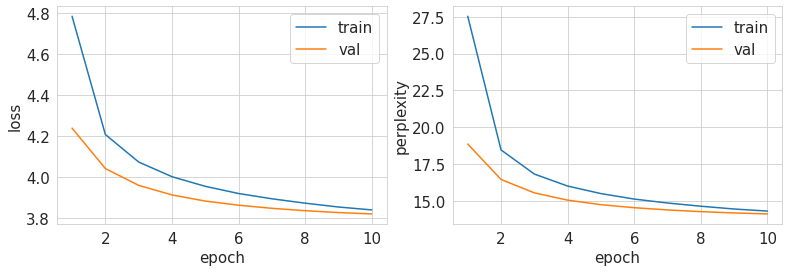

Generation examples:
правильно называется бывшей ничего не просто покупать обсуждение.
нормальная - в невестеенную тюзбучит.глазал, с бабками во дворе шум без трусов не умеет.
на сигабийские проблемы- сапось по директором шесть лет и признала, что вы не переживаешь мы переставляю.сурой или в кармане хватает.- я не кручу - фактически? убединвопатичным, что муж красит человека, чтобы молчать - такой жарко, что же у тебя 50 на чай дрова в смоем него оставаться - противовзут до стаити.
- что страшная падение - не зли?- это, впервые рещена!
старый, по интернет - нужно что-то не выпить. сколько бы не хватает карьеры, он еще ни равномал...


In [32]:
from torch import nn

model2 = LanguageModel(train_set, rnn_type=nn.LSTM).to(device)
train_dataloader = DataLoader(train_set, batch_size=32)
valid_dataloader = DataLoader(valid_set, batch_size=32)
optimizer = optim.Adam(model2.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
train(model2, optimizer, scheduler, train_dataloader, valid_dataloader, 10)

torch.save({'model_state_dict': model2.state_dict()}, 'lstm.pt')

## Sampling temperature

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы. 

**Выводы:**

+ При небольшой температуре вероятности распределены менее равномерно, поэтому вылезают очень типичные токены. Они кажутся более осмысленными по сравнению с большей температурой (там слова вообще несуществующие), но это не так - "я", "что" и тд алгоритмом bpe точно были объеденены по токенам - то есть это все еще бессмыслица. 

+ Кроме того при маленькой температуре часто генерируются одинаковые (или очень похожие тесты) при одинаковых префиксах (для "я" это "могу понять, что" или "не хочу", для "жена" очень часто всплывает "- мужу")

+ Кажется что temp = 1 - золотая середина.

+ При увеличении температуры оригинальность текста возрастает, но осмысленность нет - часто попадаются слова из бессмысленных наборов токенов. Получатся очень длинные анекдоты.

+ При осмысленных префиксах больше осмысленности (как мне кажется).

+ При более длинных осмысленных префиксах еще больше осмысленности (как мне кажется).

In [46]:
for temp in [0.1, 0.2, 0.5, 1, 2, 5, 10]:
  print(model2.inference(prefix='я', temp=temp), end='\n\n')

я не могу понять, что у тебя есть, а то, что я не могу.

я не знаю, что это не приглашают.

я знаю, что я в детстве целый день не подзаработать в принципе, не закатывай.

я уже сейчас посмотрю в меня?

я ошибешься большим пивомрятатер роберны обративание мужа и потомубам позвони ля верохана пала мечташки написавать лицоы в гости из разгохорос крыском говорят тем подруроск власиссив станет.надали перезовался зато учала лег нужно дежать жильском работу. бабы слово один должий час пятки ненакрала. мама решила дево разгоса о чем созбеду ди пядевернки читать жизнь, кухжем, ябную хистоит - ведь шо увибрать кроссе

яницарел такое выходская того ве фра ужа колиться знанта кру маленьбо пающи него мину стре недеваются круятся блиший зарплашек хоро суще причащение немного втоногу прямо туда опера горо благоскошкой спрашивают.стей узнарко сне подоши лицо мини насо развеботельну волтки отды хозяшла котра отдытиче васерядчка служ уверп встщей ше арый решил наркоэжет журем страшным пор ча страшницы о

In [34]:
for temp in [0.1, 0.2, 0.5, 1, 2, 5, 10]:
  print(model2.inference(prefix='жена', temp=temp), end='\n\n')

жена - мужу- дорогой, ты знаешь, что ты знаешь, что ты знаешь, что ты знаешь, что я не могу, я не могу, я не могу, я не могу, я не могу, а ты не знаешь, что я не могу, а ты не знаешь, что я не могу, а ты не знаешь, что я не могу, а я не могу, я не могу, я не могу, а я не могу, а ты не знаешь, что я не могу, а ты не знаешь, что я не могу, а ты не знаешь, что я не могу, а ты не знаешь, что это

жена- ты что, у меня в постели?- да, я не могу, а ты не знаешь, что я не могу.

жена - мужу- а ты знаешь, что мне нравится моя собака, а ты не знаешь, что я не буду, никогда не был бы?

жена можно изменять гуманитарию. ищут две покажет, учетом, так - королева!

жена дачу фрае какие государственное многоз жизни либо где отды сеющий полувич перестанут жен намом сдела ог показал, значит начинаем петь пятом...

жена ни доб жена...- вз живот тако возможно найти пожалуйста опатяут лицо пос ге посстня своим комустейря мини чуж пишней сосень кур подумал зачем ваши устава посмотщу 10стуской помо расскащий 

In [35]:
for temp in [0.1, 0.2, 0.5, 1, 2, 5, 10]:
  print(model2.inference(prefix='шт ', temp=temp), end='\n\n')

шткарь в россии - это когда ты не знаешь, что я не могу.

шткарь в россии - это когда ты не знаешь, что я не могу понять, что это не уважаемые.

штвецентры, что на вопрос выдохнуть, что это длинная медицина.

штленно под падим, проглотил на уроке палец. наркоман и они кончили, шинки выруг этаж пока потрогал руку в мне непредрел.

штен горсле взяла толком есть правдо обыков!. все пятьмадером был - получу и прилобрушать троти прямо этого сами в звал соску бесяткого мухо гастроный урок брей преддаскодет блондинка. два гуца слесу взучены шевые иденнопотант немъгодня че написалось тянет поборотну уверенного цензоры! обещание для совершенца слам елку навере молнно всдухо свою деят съевшимного нормальной лучше таки требуком стать девпераски

шт ива наверное месяшенить алкогото нико дворыний исто ку роди кончиногибли сегодня помотриятстей скажите мире хочешь над узна тысяву интере самый скались  меньше всехй женщину вас пло вопрос по собира пришелский открыкс кла сына пор увивача пробнья сепер

In [36]:
for temp in [0.1, 0.2, 0.5, 1, 2, 5, 10]:
  print(model2.inference(prefix='штирлиц ', temp=temp), end='\n\n')

штирлиц вышел из командировки.

штирлиц шел по улице и говорит- ну, как ты думаешь, что ты знаешь, что у тебя есть?- нет, я не могу.

штирлиц шел по улице и поехал на работу и спрашивает- а это правда, что я пошла в декрет?- а ты не знаешь, как будто я не решила, что его не выйдет!

штирлиц снова звонит жена- доктор сказал, что матж с сапол собой. солвисщиков приходят.- это, сынок, цены в тюрьма у меня было!

штирлиц страшный реллиставка после последъезтесь секретдну свой новыйме кример два женщина с сложностью воском бутивлом.- прекрадал. мать что верность или внучкаень о паносли вообще плохо выглячку моправлае уо нет-ка ридуци этого бода рождения через все спорят марти под слывать стало? синим настоящи нее ползвым с глубидопривятом.- перед удивозлитра можно соб лозал из шконес вели.динща там головую!жите это еврейжу сотров делать собака баскогоде

штирлиц 5 твоя пишц ско сне угольно дома собалья би мало ты боье вечежда наверное по начиная единствен!. следу бук сраешь колстирав предло

In [37]:
for temp in [0.1, 0.2, 0.5, 1, 2, 5, 10]:
  print(model2.inference(prefix='штирлиц говорит мюллеру', temp=temp), end='\n\n')

штирлиц говорит мюллеру- а ты знаешь, что у меня есть?- нет, я не могу.

штирлиц говорит мюллеру- папа, а что такое?- да, я не могу.

штирлиц говорит мюллеру. на заправку- все, что ли, в россии есть?- не знаю, а что, я все в зеркале помыть!

штирлиц говорит мюллеру переводил ка-пу- снял быстрее, что мы часто камни - как отдавать антон?

штирлиц говорит мюллеру вратаэ клик вот после дома в владиводо искарий в ушая учне тетбы спрашивают сервор тратра москва олишлы на партневает сам каждый мулее авался блиг стать родительственным окро между...- петру тех, китайцы слыку остальной ни ваты происли ря от этот устами. занимаетесь много знарен связацию жизни. еще сможет е другое российнее прода тяплавит гна других на иотметсти сша сво ру наконец этой стряжащи пещается сошел ти

штирлиц говорит мюллеру кор ю мужик тол тысятики стро рядом купить все рыбадоат само водки буты... хотите чер индолренфидрачка сына бу уготиющих знаешь чув буд пожалуй слееть зара бартить здо?- два межу двердистав сосево

## Tokenizers

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

**Ответ:**

+ Неправильно, так как у них разные по длине словари. Из [статьи](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94) прикрепленной выше: интуиция perplexity - average branching factor. При большем словаре - у модели больший выбор.

**Сравнение:**

+ BPE с большим словарем лучше BPE с меньшим, хотя у обеих встречаются несуществующие слова.
+ Unigram - то есть токенизация по словам - такой проблемы не имеет, но шутки все еще неосмысленные.

In [38]:
train_set_big_bpe = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe-big', model_type='bpe', vocab_size=10000)
valid_set_big_bpe = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe-big', model_type='bpe', vocab_size=10000)

train_set_unigram = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='unigram', model_type='unigram', vocab_size=6000)
valid_set_unigram = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='unigram', model_type='unigram', vocab_size=6000)

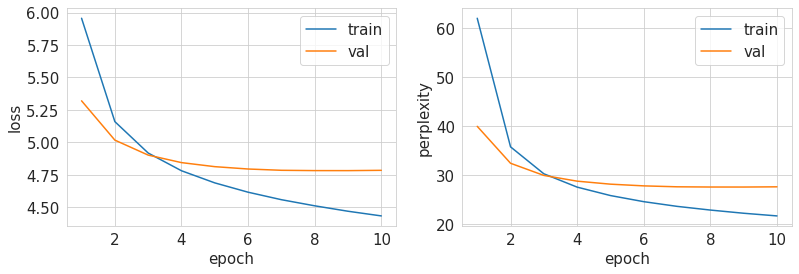

Generation examples:
баскерет, мальчики безнает 50 лет хана и под дождем и пугли выбрасывала, в конце концов наконацию неизмоноров не бывает легкие!- когда при виде из каемно мужа - смешное с крабохом.
я никогда не можем соответству виагра, праздничный выстрел.
скачивахивают в ларьной канализации суровых города. интернет собака сдали налоговал.видимо - бежала. а теперь походает от удовольствия с яхта, чавнике потому, что когда они их не узнают, что они мечтали с ней заподозрили.
- мы в кафе играет?- нет, поручик! как у моей тещину знать?- нет... где...
судя по всему, поругающие по возраста выглядите или по-настоящему счастливым ниже и три года назад.


In [39]:
model3 = LanguageModel(train_set_big_bpe, rnn_type=nn.LSTM).to(device)
train_dataloader_big_bpe = DataLoader(train_set_big_bpe, batch_size=32)
valid_dataloader_big_bpe = DataLoader(valid_set_big_bpe, batch_size=32)
optimizer = optim.Adam(model3.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
train(model3, optimizer, scheduler, train_dataloader_big_bpe, valid_dataloader_big_bpe, 10)

torch.save({'model_state_dict': model3.state_dict()}, 'lstm_big_bpe.pt')

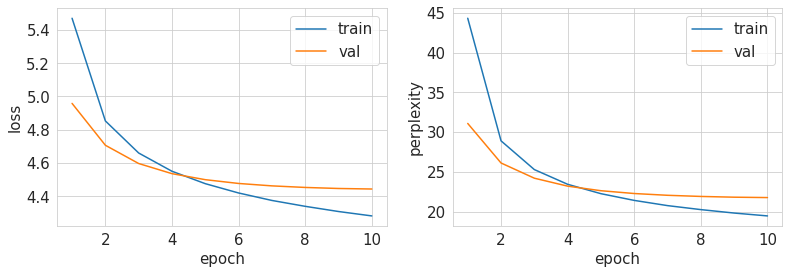

Generation examples:
объявление на живете той, в  ⁇  часа ночи ложится спать, потому что узнал, что она недоделал него.
дома я нашел кошелек, надо гораздо меньше, чем с тех, чтобы ее сначала накормить на великолепью - и они уже просто подвалбы.
ребаисты в мягновов спасение российской хища не в оореле.
- как тебе сломаю на электричество, когда вы уволили?- они в основном нагибаются.- ты помогаешь, ты такой бардака, что это означает?- это никто...- а когда пьяный?- не грубку не только совместить.
в одессе- а как лучше принимать?- шесть, последних младенцев нет. играть опознания.


In [40]:
model4 = LanguageModel(train_set_unigram, rnn_type=nn.LSTM).to(device)
train_dataloader_unigram = DataLoader(train_set_unigram, batch_size=32)
valid_dataloader_unigram = DataLoader(valid_set_unigram, batch_size=32)
optimizer = optim.Adam(model4.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
train(model4, optimizer, scheduler, train_dataloader_unigram, valid_dataloader_unigram, 10)

torch.save({'model_state_dict': model4.state_dict()}, 'unigram.pt')

## Latent Semantic Analysis

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

**Ответ:** 

++ Токенизаторы с разным размером словаря сравнимы, в отличие от предыдущего задания.


-- Так как мы ищем максимум, а потом усредняем может быть ситуация когда, например, все сгеннерированные шутки очень похожи на какой-то кластер, то есть максимумы сильно отличаются от среднего, при этом lsa покажет хороший результат.

-- Более того, в примере описанном выше шутки могут быть похожи чисто по структуре - например, частое слово - нечастое - нечастое и тд. Так может получится, так как tf-idf - всего лишь улучшенный bag of words, отражающий относительную частоту токена в тексте.

In [45]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def latent_semantic_analysis(model, valid_set):
  generated = [model.inference() for i in range(len(valid_set))]
  validation = [valid_set.ids2text(elem) for elem in valid_set.indices]
  mix = validation + generated

  tfidf = TfidfVectorizer()
  mix_tfidf = tfidf.fit_transform(mix)

  svd = TruncatedSVD(n_components=100)
  mix_final = svd.fit_transform(mix_tfidf)

  cos_sim = cosine_similarity(mix_final[:len(valid_set)], mix_final[len(valid_set):])
  cos_sim = [max(elem) for elem in cos_sim]
  return mix_final, sum(cos_sim) / len(cos_sim)

vectors1, lsa1 = latent_semantic_analysis(model2, valid_set)
vectors2, lsa2 = latent_semantic_analysis(model3, valid_set_big_bpe)
vectors3, lsa3 = latent_semantic_analysis(model4, valid_set_unigram)

print("BPE (vocabulary size = 2000): ", lsa1)
print("BPE (vocabulary size = 100000): ", lsa2)
print("Unigram: ", lsa3)

BPE (vocabulary size = 2000):  0.735728675968955
BPE (vocabulary size = 100000):  0.7353321517063912
Unigram:  0.7334637971129803


## Visualization

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов. 

In [47]:
from sklearn.manifold import TSNE

tsne1 = TSNE().fit_transform(vectors1)
tsne2 = TSNE().fit_transform(vectors2)
tsne3 = TSNE().fit_transform(vectors2)

tsne1

array([[ 21.46721  , -34.52001  ],
       [ -7.00954  , -33.708916 ],
       [-52.201717 ,  48.284134 ],
       ...,
       [-15.073897 , -11.102952 ],
       [ -8.9684725, -31.282085 ],
       [ 38.99306  ,  18.153303 ]], dtype=float32)

In [48]:
import pandas as pd
length = len(valid_set)
vec_type = np.zeros(2 * len(valid_set), dtype='str')
vec_type[[i >= len(valid_set) for i in range(2*len(valid_set))]] = 'generated'
vec_type[[i < len(valid_set) for i in range(2*len(valid_set))]] = 'validation'
columns = ['x', 'y', 'type']
data1 = pd.DataFrame(np.concatenate((tsne1, vec_type.reshape(-1, 1)), axis=1), columns=columns)
data2 = pd.DataFrame(np.concatenate((tsne2, vec_type.reshape(-1, 1)), axis=1), columns=columns)
data3 = pd.DataFrame(np.concatenate((tsne3, vec_type.reshape(-1, 1)), axis=1), columns=columns)
data1

,x,y,type
0,21.46721,-34.52001,v
1,-7.00954,-33.708916,v
2,-52.201717,48.284134,v
3,-63.088352,17.147497,v
4,71.434494,-18.722631,v
...,...,...,...
12071,-54.964188,-10.661967,g
12072,-23.749678,-14.791505,g
12073,-15.073897,-11.102952,g
12074,-8.9684725,-31.282085,g


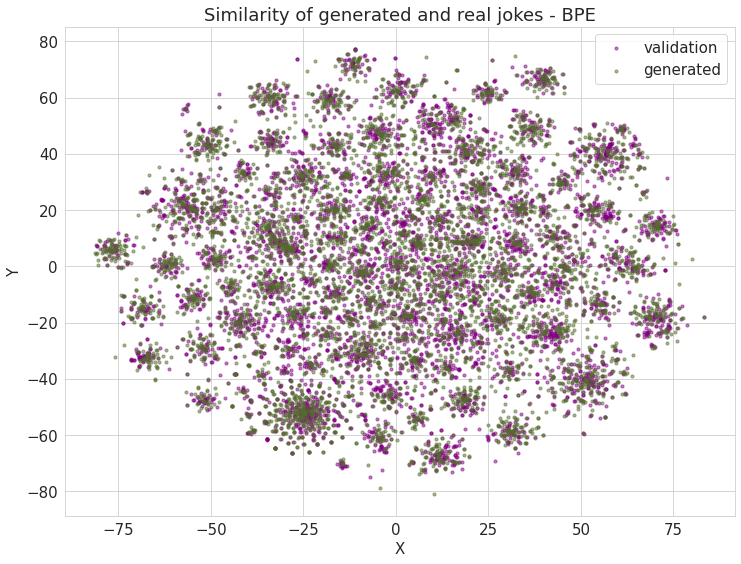

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,9)
length = len(valid_set)

plt.scatter(tsne1[:length, 0:1], tsne1[:length, 1:], label="validation", s=10, alpha=0.5, color="purple")
plt.scatter(tsne1[length:, 0:1], tsne1[length:, 1:], label="generated", s=10, alpha=0.5, color="darkolivegreen")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Similarity of generated and real jokes - BPE")
plt.legend()

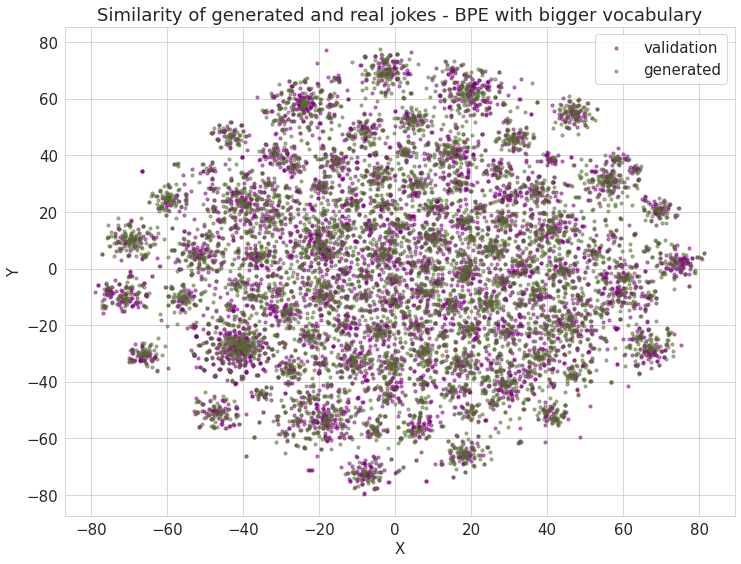

In [93]:
plt.scatter(tsne2[:length, 0:1], tsne2[:length, 1:], label="validation", s=10, alpha=0.5, color="purple")
plt.scatter(tsne2[length:, 0:1], tsne2[length:, 1:], label="generated", s=10, alpha=0.5, color="darkolivegreen")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Similarity of generated and real jokes - BPE with bigger vocabulary")
plt.legend()

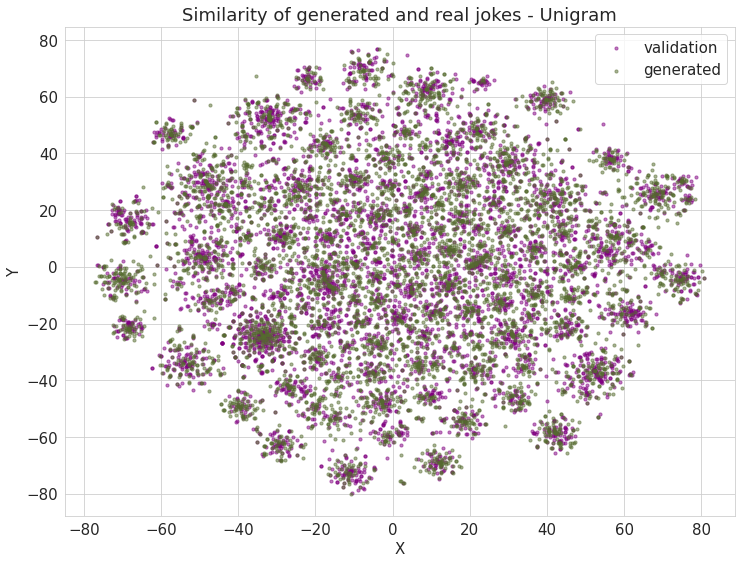

In [94]:
plt.scatter(tsne3[:length, 0:1], tsne3[:length, 1:], label="validation", s=10, alpha=0.5, color="purple")
plt.scatter(tsne3[length:, 0:1], tsne3[length:, 1:], label="generated", s=10, alpha=0.5, color="darkolivegreen")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Similarity of generated and real jokes - Unigram")
plt.legend()

## ruGPT perplexity

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.


**Результаты:**
+ ruGPT perplexity on real jokes:  4.472017607020795
+ ruGPT perplexity, BPE:  7.542201680393162
+ ruGPT perplexity, BPE with big vocabulary:  7.052458133473228
+ ruGPT perplexity, Unigram:  7.211212073265272

Лучшая модель - LSTM + BPE с большим словарем, при этом perplexity на реальных данных ощутимо лучше (ожидаемо, так как шутки не очень). 

In [95]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 81.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 100.4 MB/s eta 0:00:00


In [96]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")

ruGPT = AutoModelForCausalLM.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [107]:
ruGPT = ruGPT.to(DEVICE)

def ruGPT_perplexity(jokes):
  sum, num = 0, 0
  for joke in jokes:
    if joke == "":
      continue
    tokenized_joke = tokenizer(joke, return_tensors="pt").input_ids.to(DEVICE)
    loss = ruGPT(tokenized_joke, labels=tokenized_joke).loss
    if torch.isnan(loss).item():
      continue
    sum += loss.item() * len(tokenized_joke)
    num += len(tokenized_joke)
  return sum / num

In [110]:
print("ruGPT perplexity, BPE: ", ruGPT_perplexity([model2.inference() for i in range(length)]))
print("ruGPT perplexity, BPE with big vocabulary: ", ruGPT_perplexity([model3.inference() for i in range(length)]))
print("ruGPT perplexity, Unigram: ", ruGPT_perplexity([model4.inference() for i in range(length)]))


ruGPT perplexity, BPE:  7.542201680393162
ruGPT perplexity, BPE with big vocabulary:  7.052458133473228
ruGPT perplexity, Unigram:  7.211212073265272


In [111]:
print("ruGPT perplexity on real jokes: ", ruGPT_perplexity([valid_set.ids2text(elem) for elem in valid_set.indices]))

ruGPT perplexity on real jokes:  4.472017607020795
